# Clean data


In [1]:
import mne
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import autoreject


In [2]:
config = toml.load("../../.env.toml")

project_path = config["project"]["path"]
data_path = f"{project_path}/data/raw/BIDS" #Into which directory the data should go
files = [file for file in Path(data_path).glob('**/*.set')]

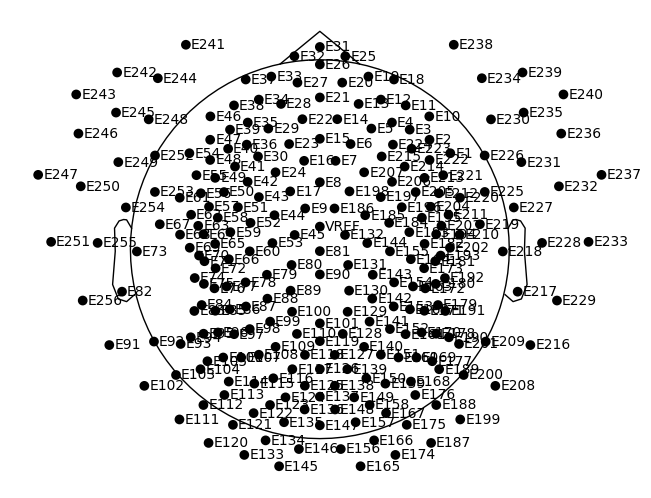

In [3]:
# --- Check types of Channels ---
raw = mne.io.read_raw_eeglab(files[0], preload=True)
ch_name_type = dict(zip(raw.ch_names, raw.get_channel_types()))

ch_name_ecg = [name for name in raw.ch_names if name in 'ECG']
dict_ecg = {sub[0] : 'ecg' for sub in (ele.split() for ele in ch_name_ecg)}
raw.set_channel_types(dict_ecg)

# documented here https://mne.discourse.group/t/mismatching-between-channel-names-and-types-when-read-raw-eeglab/5811

raw.set_montage('GSN-HydroCel-257', match_alias= {'VREF' :'Cz'})
raw.plot_sensors(show_names=True);

- Trials and triggers codes are read and only eyes-closed segments are selected
- Very basic pre-processing includes: demeaning, detrending, low-pass filter below 60Hz, re-referencing to mastoid reference, bandpass filtering of possible 50Hz line-noise and resampling to 256Hz.
- Optional visual inspection after basic pre-processing
- Optional reconstruction of noisy channels (though only use this if a channel is absolutely rubbish!)
- Optional removal of noise using ICA decomposition

Sources;

- [EEG processing pipeline with autoreject - 💬 Support & Discussions - MNE Forum](https://mne.discourse.group/t/eeg-processing-pipeline-with-autoreject/3443/5)


In [4]:
filter_params = {'l_freq': 1,
                 'h_freq': 45,
                 'h_trans_bandwidth': 5,
                 'fir_design': 'firwin2',
                 'phase': 'zero-double'}
raw_cropped = raw.crop(tmin=0, tmax=300, include_tmax=True)
raw_cropped.filter(**filter_params)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-12 dB cutoff frequency: 47.50 Hz)
- Filter length: 1650 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"257 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,45.00 Hz


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 751 original time points ...
0 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


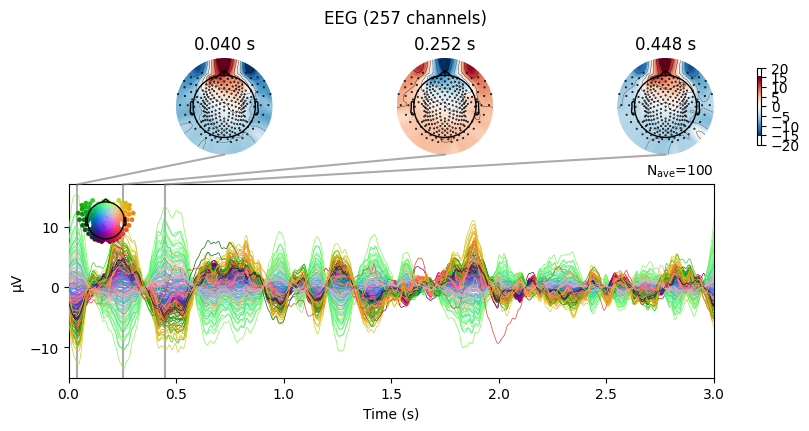

In [8]:
events = mne.make_fixed_length_events(raw        = raw_cropped,
                                      start      = 0,
                                      stop       = None,
                                      duration   = 3,
                                      overlap    = 0,
                                      first_samp = False)

# Create  Epochs object
epochs = mne.Epochs(raw      = raw_cropped,
                    events   = events,
                    tmin     = 0,
                    tmax     = 3,
                    detrend  = 1,
                    baseline = None,
                    preload  = True)
epochs.average().detrend().plot_joint();

In [9]:
mne.viz.plot_raw(raw);

Using qt as 2D backend.
Using pyopengl with version 3.1.7


## Steps of analysis

- filter out above 256 Hz (automatically done by mne before resampling)
- Resample to 256 Hz


## Autoreject without any other preprocessing


In [10]:
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11,
                           n_jobs=1, verbose=True)
ar.fit(epochs[:20])  # fit on a few epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

NameError: name 'autoreject' is not defined